Collect Ham and Spam email files in a list with corresponding lable

In [1]:
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.utils import shuffle

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
pd.options.display.max_columns = 1000

   
***
# <span style = 'color:darkblue'> <center> $ \textrm {Function Definitions} $

</span>

In [2]:
from sklearn.base import TransformerMixin,BaseEstimator
class ToDenseTransformer(BaseEstimator, TransformerMixin):

    # here you define the operation it should perform
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    # just return self
    def fit(self, X, y=None, **fit_params):
        return self

***    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Data Wrangling} $

***
***
</span>

***
## <span style = 'color:darkblue'> <center> $ \textrm {Read Randomly Distributed Ham & Spam Email Dataframe} $

</span>


In [3]:
EmailList = pd.read_csv('EmailList.csv')

In [4]:
UnseenEmailList = pd.read_csv('UnseenEmailList.csv')

***
## <span style = 'color:darkblue'> <center> $ \textrm {Train and Test Data Distribution} $

</span>
</div>

In [5]:
# Split train and test vectors
X_train, X_test, y_train, y_test = train_test_split(EmailList['Text'], \
                                                    EmailList['Ham1/Spam0'], \
                                                    test_size = 0.25, random_state = 40)


In [6]:
# Split train and test vectors
unseen_X_train, unseen_X_test, unseen_y_train, unseen_y_test = train_test_split(UnseenEmailList['Text'], \
                                                    UnseenEmailList['Ham1/Spam0'], \
                                                    test_size = 0.25, random_state = 40)


***    
***
# <span style = 'color:darkblue'> <center> $ \textrm {ANALYSIS} $

***
***
</span>

# <span style = 'color:darkblue'> <center> $ \textrm {Machine Learning Models} $

</span>

In [7]:
# Change vocabulary size by reducing the min/max number of document term frequency
TFIDF_ngram = [1, 2]
TFIDF_min = [0.01, 0.05, 0.1]
TFIDF_max = [0.11, 0.5, 0.8]
TFIDF_max_feat = [100, None]
model_randomState = 40

***
<center> 
    
### Logistic Regression
#### All solvers performe very well with no difference
***

In [8]:
pkList = pd.DataFrame()
paramList = pd.DataFrame()
pList=[]
pLst = []
# All LogisticRegression solvers produced same score/result
for n in TFIDF_ngram:
    for tfidf_min in TFIDF_min:
        for tfidf_max in TFIDF_max:
            for tfidf_max_feat in TFIDF_max_feat:
                # TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.
                pipelineLR = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words=None, ngram_range = [1,n], \
                                                                      min_df = tfidf_min, max_df = tfidf_max, \
                                                                      max_features = tfidf_max_feat)), \
                                       ('to_dens', ToDenseTransformer()), \
                                       ('pca', PCA()), \
                                       ('log_reg', LogisticRegression(solver = 'lbfgs', \
                                                                      random_state = model_randomState))])
                pipelineLR = pipelineLR.fit(X_train, y_train)
                y_pred_train_LR = pipelineLR.predict(X_train)
                y_pred_test_LR = pipelineLR.predict(X_test)
                # Predict independent emails, unseen_X_test, based on original train set
                unseen_y_pred_test_LR = pipelineLR.predict(unseen_X_test)
                # Accuracy score prediction performance
                train_score = np.round(metrics.accuracy_score(y_train, y_pred_train_LR),4)
                # Test predict F1 Score for comparison
                mean_f1 = np.round(metrics.f1_score(y_test, y_pred_test_LR, average='micro'),4)
                unseen_mean_f1 = np.round(metrics.f1_score(unseen_y_test, unseen_y_pred_test_LR, average='micro'),4)
                pLst.append(['Logistic Regression', train_score, mean_f1, unseen_mean_f1])
                pList.append(pipelineLR.get_params(deep = True).values())

pKeys = pipelineLR.get_params(deep = True).keys()
# append list to DataFrame
LR_score_cols = ['Model', 'Train Score', 'F1-Score', 'unseen_F1-Score']
pkList = pd.DataFrame(pLst, columns = LR_score_cols)
paramList = pd.DataFrame(pList, columns = pKeys)
LR_performance = pkList.join(paramList)
#LR_performance

In [9]:
# TFDIF Parameters Reference - same for all models
tfidf_params = LR_performance.T[17:21].T
#tfidf_params

In [10]:
# Loggistic Regression - Reference Table for Unchanged Parameters
LR_ref_param = LR_performance.T[4:17].append(LR_performance.T[21:]).T.iloc[[0]].T
LR_ref_param.columns = ['LR Analysis General Settings']
#Display table
#LR_ref_param

In [11]:
# Logistic Regression Model Performance Score Reference
LR_model_scores = LR_performance.T[0:4].T
#LR_model_scores

In [12]:
LRdata_df = LR_model_scores.join(tfidf_params)
#LRdata_df

***
<center>

### Naive Bayes
#### Performance improves notably when alpha = 'False'
***

In [13]:
pkList = pd.DataFrame()
paramList = pd.DataFrame()
pList=[]
pLst = []
#
# MultinomialNB Paramaters ]alpha' and 'fit_prior' used as ML Hyperparameters
# alpha -> Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
# fit_prior -> Whether to learn class prior probabilities or not. If false, a uniform prior will be used.
#

for n in TFIDF_ngram:
    for tfidf_min in TFIDF_min:
        for tfidf_max in TFIDF_max:
            for tfidf_max_feat in TFIDF_max_feat:
                # TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.
                pipelineNB = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words=None, ngram_range = [1,n], \
                                                                      min_df = tfidf_min, max_df = tfidf_max, \
                                                                      max_features = tfidf_max_feat)), \
                                       ('nb_classifier', MultinomialNB())])
                pipelineNB = pipelineNB.fit(X_train, y_train)
                y_pred_train_NB = pipelineNB.predict(X_train)
                y_pred_test_NB = pipelineNB.predict(X_test)
                # Predict independent emails, unseen_X_test, based on original train set
                unseen_y_pred_test_NB = pipelineNB.predict(unseen_X_test)
                # Accuracy score prediction performance
                train_score = np.round(metrics.accuracy_score(y_train, y_pred_train_NB),4)
                # Test predict F1 Score for comparison
                mean_f1 = np.round(metrics.f1_score(y_test, y_pred_test_NB, average='micro'),4)
                unseen_mean_f1 = np.round(metrics.f1_score(unseen_y_test, unseen_y_pred_test_NB, average='micro'),4)
                pLst.append(['Naive Bayes', train_score, mean_f1, unseen_mean_f1])
                pList.append(pipelineNB.get_params(deep = True).values())

pKeys = pipelineNB.get_params(deep = True).keys()
# append list to DataFrame
NB_score_cols = ['Model', 'Train Score', 'F1-Score', 'unseen_F1-Score']
pkList = pd.DataFrame(pLst, columns = NB_score_cols)
paramList = pd.DataFrame(pList, columns = pKeys)
NB_performance = pkList.join(paramList)

In [14]:
# Loggistic Regression - Reference Table for Unchanged Parameters
NB_ref_param = NB_performance.T[4:15].append(NB_performance.T[19:]).T.iloc[[0]].T
NB_ref_param.columns = ['NB Analysis General Settings']
#Display table
#NB_ref_param

In [15]:
# Naive Bayes Model Performance Score Reference
NB_model_scores = NB_performance.T[0:4].T
#NB_model_scores

In [16]:
NBdata_df = NB_model_scores.join(tfidf_params)
#NBdata_df

***
<center>
    
### SVC (Support Vector Classifier) 
#### Best performance are with kernel set to rbf, sigmoid, linear and poly respectively
#### where gamma set to 'scale' performs better than 'auto'
***

In [17]:
pkList = pd.DataFrame()
paramList = pd.DataFrame()
pList=[]
pLst = []

for n in TFIDF_ngram:
    for tfidf_min in TFIDF_min:
        for tfidf_max in TFIDF_max:
            for tfidf_max_feat in TFIDF_max_feat:
                # TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.
                pipelineSVC = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words=None, ngram_range = [1,n], \
                                                                       min_df = tfidf_min, max_df = tfidf_max, \
                                                                       max_features = tfidf_max_feat)), \
                                        ('svc', SVC(kernel = 'linear', gamma = 'auto', \
                                                    random_state = model_randomState))])
                pipelineSVC = pipelineSVC.fit(X_train, y_train)
                y_pred_train_SVC = pipelineSVC.predict(X_train)
                y_pred_test_SVC = pipelineSVC.predict(X_test)
                # Predict independent emails, unseen_X_test, based on original train set
                unseen_y_pred_test_SVC = pipelineSVC.predict(unseen_X_test)
                # Accuracy score prediction performance
                train_score = np.round(metrics.accuracy_score(y_train, y_pred_train_SVC),4)
                # Test predict F1 Score for comparison
                mean_f1 = np.round(metrics.f1_score(y_test, y_pred_test_SVC, average='micro'),4)
                unseen_mean_f1 = np.round(metrics.f1_score(unseen_y_test, unseen_y_pred_test_SVC, average='micro'),4)
                pLst.append(['SVC', train_score, mean_f1, unseen_mean_f1])
                pList.append(pipelineSVC.get_params(deep = True).values())

pKeys = pipelineSVC.get_params(deep = True).keys()
# append list to DataFrame
SVC_score_cols = ['Model', 'Train Score', 'F1-Score', 'unseen_F1-Score']
pkList = pd.DataFrame(pLst, columns = SVC_score_cols)
paramList = pd.DataFrame(pList, columns = pKeys)

SVC_performance = pkList.join(paramList)

In [18]:
# Loggistic Regression - Reference Table for Unchanged Parameters
SVC_ref_param = SVC_performance.T[4:15].append(SVC_performance.T[19:]).T.iloc[[0]].T
SVC_ref_param.columns = ['SVC Analysis General Settings']
#Display table
#SVC_ref_param

In [19]:
# SVC Model Performance Score Reference
SVC_model_scores = SVC_performance.T[0:4].T
#SVC_model_scores

In [20]:
SVCdata_df = SVC_model_scores.join(tfidf_params)
#SVCdata_df

***
<center>

### Linear SVC
#### Performs better with fit_intercept  set to 'False' for loss set to 'hinge' or 'squared_hinge'
#### When fit_intercept is set to False, setting loss to 'hinge' performs better
***

In [21]:
pkList = pd.DataFrame()
paramList = pd.DataFrame()
pList=[]
pLst = []

for n in TFIDF_ngram:
    for tfidf_min in TFIDF_min:
        for tfidf_max in TFIDF_max:
            for tfidf_max_feat in TFIDF_max_feat:
                # TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.
                pipelineLSVC = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words=None, ngram_range = [1,n], \
                                                                        min_df = tfidf_min, max_df = tfidf_max, \
                                                                        max_features = tfidf_max_feat)), \
                                         ('lsvc', LinearSVC(random_state = model_randomState))])
                pipelineLSVC = pipelineLSVC.fit(X_train, y_train)
                y_pred_train_LSVC = pipelineLSVC.predict(X_train)
                y_pred_test_LSVC = pipelineLSVC.predict(X_test)
                # Predict independent emails, unseen_X_test, based on original train set
                unseen_y_pred_test_LSVC = pipelineLSVC.predict(unseen_X_test)
                # Accuracy score prediction performance
                train_score = np.round(metrics.accuracy_score(y_train, y_pred_train_LSVC),4)
                # Test predict F1 Score for comparison
                mean_f1 = np.round(metrics.f1_score(y_test, y_pred_test_LSVC, average='micro'),4)
                unseen_mean_f1 = np.round(metrics.f1_score(unseen_y_test, unseen_y_pred_test_LSVC, average='micro'),4)
                pLst.append(['Linear SVC', train_score, mean_f1, unseen_mean_f1])
                pList.append(pipelineLSVC.get_params(deep = True).values())

pKeys = pipelineLSVC.get_params(deep = True).keys()
# append list to DataFrame
LSVC_score_cols = ['Model', 'Train Score', 'F1-Score', 'unseen_F1-Score']
pkList = pd.DataFrame(pLst, columns = LSVC_score_cols)
paramList = pd.DataFrame(pList, columns = pKeys)

LSVC_performance = pkList.join(paramList)

In [22]:
# Loggistic Regression - Reference Table for Unchanged Parameters
LSVC_ref_param = LSVC_performance.T[4:15].append(LSVC_performance.T[19:]).T.iloc[[0]].T
LSVC_ref_param.columns = ['LSVC Analysis General Settings']
#Display table
#LSVC_ref_param

In [23]:
# Linear SVCModel Performance Score Reference
LSVC_model_scores = LSVC_performance.T[0:4].T
#LSVC_model_scores

In [24]:
LSVCdata_df = LSVC_model_scores.join(tfidf_params)
#LSVCdata_df

***
<center>
    
### SGD Classifer
#### Loss set to 'hinge' and 'modified_huber' perform best with fit_intercept set to 'False'
#### Worst perfoming loss functions were ‘squared_loss’ and ‘squared_epsilon_insensitive’ with score of  around 0.5
***

In [25]:
pkList = pd.DataFrame()
paramList = pd.DataFrame()
pList=[]
pLst = []
#
# loss : str, default: ‘hinge’
#     The loss function to be used. Defaults to ‘hinge’, which gives a linear SVM.
#     The possible options are ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’,
#     or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.
#     The ‘log’ loss gives logistic regression, a probabilistic classifier. ‘modified_huber’ is another 
#     smooth loss that brings tolerance to outliers as well as probability estimates. ‘squared_hinge’ is like 
#     hinge but is quadratically penalized. ‘perceptron’ is the linear loss used by the perceptron algorithm. 
#     The other losses are designed for regression but can be useful in classification as well; see SGDRegressor 
#     for a description.
#
# fit_intercept : bool
#     Whether the intercept should be estimated or not. 
#     If False, the data is assumed to be already centered. Defaults to True.
#

for n in TFIDF_ngram:
    for tfidf_min in TFIDF_min:
        for tfidf_max in TFIDF_max:
            for tfidf_max_feat in TFIDF_max_feat:
                # TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.
                pipelineSGD = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words=None, ngram_range = [1,n], \
                                                                       min_df = tfidf_min, max_df = tfidf_max, \
                                                                       max_features = tfidf_max_feat)), \
                                        ('sgd', SGDClassifier(max_iter = 1000, random_state = model_randomState))])
                pipelineSGD = pipelineSGD.fit(X_train, y_train)
                y_pred_train_SGD = pipelineSGD.predict(X_train)
                y_pred_test_SGD = pipelineSGD.predict(X_test)
                # Predict independent emails, unseen_X_test, based on original train set
                unseen_y_pred_test_SGD = pipelineSGD.predict(unseen_X_test)
                # Accuracy score prediction performance
                train_score = np.round(metrics.accuracy_score(y_train, y_pred_train_SGD),4)
                # Test predict F1 Score for comparison
                mean_f1 = np.round(metrics.f1_score(y_test, y_pred_test_SGD, average='micro'),4)
                unseen_mean_f1 = np.round(metrics.f1_score(unseen_y_test, unseen_y_pred_test_SGD, average='micro'),4)
                pLst.append(['SGD', train_score, mean_f1, unseen_mean_f1])
                pList.append(pipelineSGD.get_params(deep = True).values())

pKeys = pipelineSGD.get_params(deep = True).keys()
# append list to DataFrame
SGD_score_cols = ['Model', 'Train Score', 'F1-Score', 'unseen_F1-Score']
pkList = pd.DataFrame(pLst, columns = SGD_score_cols)
paramList = pd.DataFrame(pList, columns = pKeys)
s_paramList = paramList[['tfidf_vect__max_df', \
                         'tfidf_vect__max_features', \
                         'tfidf_vect__min_df', \
                         'tfidf_vect__ngram_range']]

SGD_performance = pkList.join(paramList)

In [26]:
# Loggistic Regression - Reference Table for Unchanged Parameters
SGD_ref_param = SGD_performance.T[4:15].append(SGD_performance.T[19:]).T.iloc[[0]].T
#Display table
SGD_ref_param.columns = ['SGD Analysis General Settings']
#SGD_ref_param

In [27]:
# SGD Model Performance Score Reference
SGD_model_scores = SGD_performance.T[0:4].T
#SGD_model_scores

In [28]:
SGDdata_df = SGD_model_scores.join(tfidf_params)
#SGDdata_df

***
***
# <span style = 'color:darkblue'> <center> $ \textrm {RESULTS} $

***
***

***
***
# <span style = 'color:darkblue'> <center> $ \textrm {Tables} $

In [29]:
display(Markdown(r'<ul></ul><center> $ \color{darkblue} {\Large { \textit {Model Performance Table} } }  $'))
hypParamTable = LRdata_df.append(NBdata_df).append(SVCdata_df).append(LSVCdata_df)
hypParamTable = hypParamTable.append(SGDdata_df).sort_values(by = 'unseen_F1-Score', ascending = False)
hypParamTable.head(10)

<ul></ul><center> $ \color{darkblue} {\Large { \textit {Model Performance Table} } }  $

,Model,Train Score,F1-Score,unseen_F1-Score,tfidf_vect__max_df,tfidf_vect__max_features,tfidf_vect__min_df,tfidf_vect__ngram_range
19,Logistic Regression,0.9907,0.9801,0.9824,0.11,NaN,0.01,"[1, 2]"
1,Logistic Regression,0.9863,0.9744,0.9797,0.11,NaN,0.01,"[1, 1]"
19,SVC,0.9946,0.9782,0.9724,0.11,NaN,0.01,"[1, 2]"
1,SGD,0.992,0.9778,0.9698,0.11,NaN,0.01,"[1, 1]"
1,SVC,0.9899,0.9774,0.969,0.11,NaN,0.01,"[1, 1]"
3,Naive Bayes,0.9731,0.9698,0.9686,0.5,NaN,0.01,"[1, 1]"
5,Naive Bayes,0.9733,0.9705,0.9675,0.8,NaN,0.01,"[1, 1]"
19,Naive Bayes,0.9701,0.9652,0.9659,0.11,NaN,0.01,"[1, 2]"
1,Naive Bayes,0.963,0.964,0.9613,0.11,NaN,0.01,"[1, 1]"
21,Naive Bayes,0.974,0.9686,0.9602,0.5,NaN,0.01,"[1, 2]"


***
***
# <span style = 'color:darkblue'> <center> $ \textrm {Plots} $

In [30]:
modelColorCodeTable = pd.DataFrame([['Reds', 'White'],\
                                    ['Purples', 'Red'], \
                                    ['Blues', 'Black'], \
                                    ['Grays', 'Blue'], \
                                    ['Greens', 'Yellow']], \
                                   index = ['Logistic Regression','Naive Bayes', \
                                            'SVC (Support Vector Classifier)','Linear SVC','SGD'],
                                   columns = ['Violine Plot Palette', 'Swarmplot color'])

,Violine Plot Palette,Swarmplot color
Logistic Regression,Reds,White
Naive Bayes,Purples,Red
SVC (Support Vector Classifier),Blues,Black
Linear SVC,Grays,Blue
SGD,Greens,Yellow


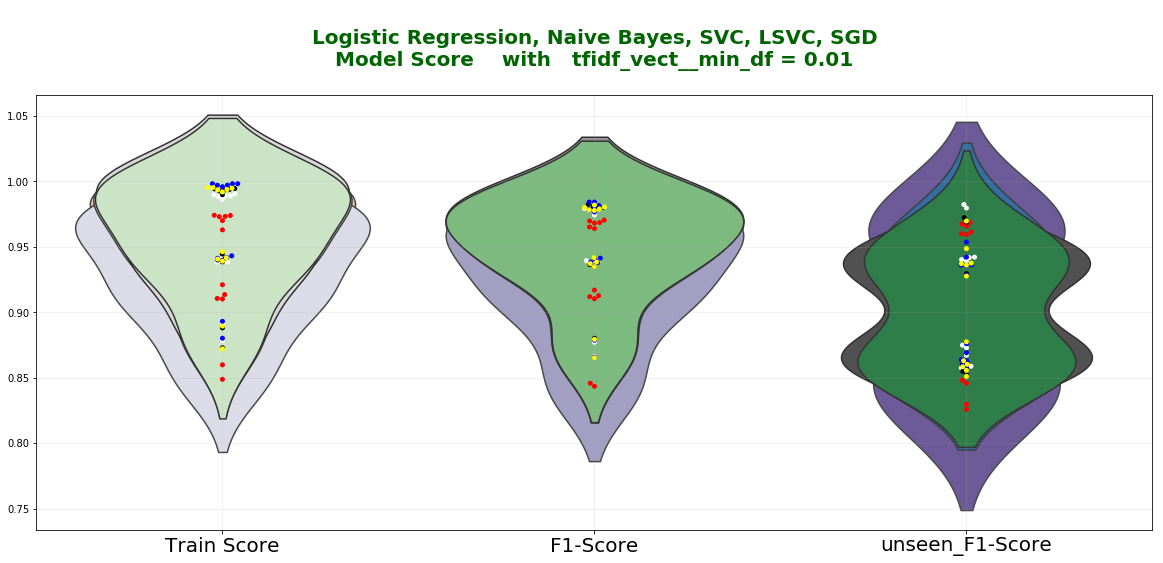

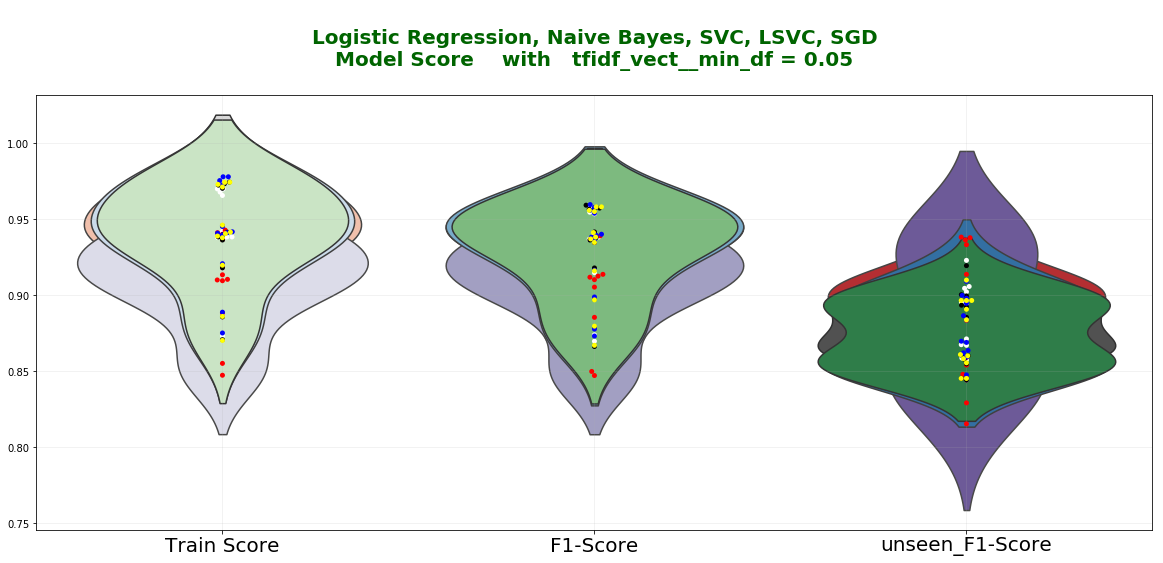

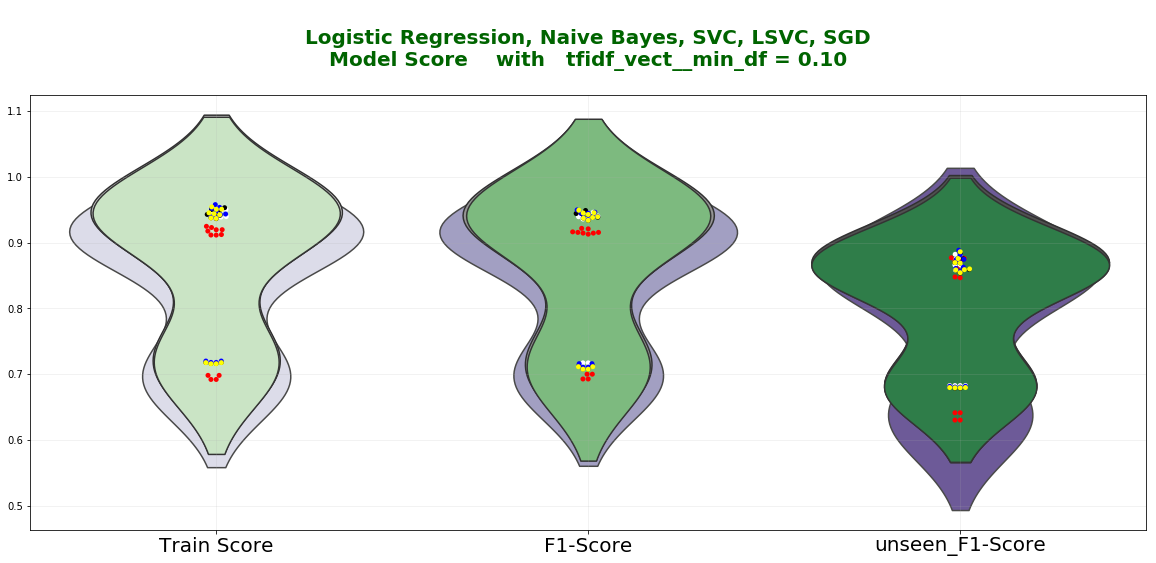

In [31]:
display(modelColorCodeTable)
for i in list(range(3)):
    # Filter Logistic Regression data by max_df sort by scores
    LRscores_min_df = \
    LRdata_df[LRdata_df.loc[:,'tfidf_vect__min_df'] == TFIDF_min[i]].sort_values(by = ['unseen_F1-Score'], \
                                                                                 ascending = False)
    # Filter Naive Bayes data by max_df sort by scores
    NBscores_min_df = \
    NBdata_df[NBdata_df.loc[:,'tfidf_vect__min_df'] == TFIDF_min[i]].sort_values(by = ['unseen_F1-Score'], \
                                                                                 ascending = False)
    # Filter data by max_df sort by scores
    SVCscores_min_df = \
    SVCdata_df[SVCdata_df.loc[:,'tfidf_vect__min_df'] == TFIDF_min[i]].sort_values(by = ['unseen_F1-Score'], \
                                                                                 ascending = False)
    # Filter data by max_df sort by scores
    LSVCscores_min_df = \
    LSVCdata_df[LSVCdata_df.loc[:,'tfidf_vect__min_df'] == TFIDF_min[i]].sort_values(by = ['unseen_F1-Score'], \
                                                                                 ascending = False)
        # Filter Naive Bayes data by max_df sort by scores
    SGDscores_min_df = \
    SGDdata_df[SGDdata_df.loc[:,'tfidf_vect__min_df'] == TFIDF_min[i]].sort_values(by = ['unseen_F1-Score'], \
                                                                                 ascending = False)
    if i == 0:
        #display(LRscores_min_df.T.iloc[0:5].T.join())
        print('\n')
    _ = plt.figure(figsize = (20,8))
    _ = plt.title('\nLogistic Regression, Naive Bayes, SVC, LSVC, SGD\nModel Score    with   tfidf_vect__min_df = %0.2f\n' %TFIDF_min[i], \
                  size = 20, color = 'darkgreen', fontweight = 'bold')
    # Logistic Regression
    _ = sns.violinplot(data = (LRscores_min_df['Train Score'], \
                               LRscores_min_df['F1-Score'], \
                               LRscores_min_df['unseen_F1-Score']), \
                       palette= 'Reds', inner = None)
    _ = sns.swarmplot(data = (LRscores_min_df['Train Score'], \
                              LRscores_min_df['F1-Score'], \
                              LRscores_min_df['unseen_F1-Score']), \
                      color='white', edgecolor='gray')
    # Naive Bayes
    _ = sns.violinplot(data = (NBscores_min_df['Train Score'], \
                               NBscores_min_df['F1-Score'], \
                               NBscores_min_df['unseen_F1-Score']), \
                       palette= 'Purples', inner = None)
    _ = sns.swarmplot(data = (NBscores_min_df['Train Score'], \
                              NBscores_min_df['F1-Score'], \
                              NBscores_min_df['unseen_F1-Score']), \
                      color='r', edgecolor='gray')
    # SVC
    _ = sns.violinplot(data = (SVCscores_min_df['Train Score'], \
                               SVCscores_min_df['F1-Score'], \
                               SVCscores_min_df['unseen_F1-Score']), \
                       palette= 'Blues', inner = None)
    _ = sns.swarmplot(data = (SVCscores_min_df['Train Score'], \
                              SVCscores_min_df['F1-Score'], \
                              SVCscores_min_df['unseen_F1-Score']), \
                      color='black', edgecolor='gray')
    # LSVC
    _ = sns.violinplot(data = (LSVCscores_min_df['Train Score'], \
                               LSVCscores_min_df['F1-Score'], \
                               LSVCscores_min_df['unseen_F1-Score']), \
                       palette= 'Greys', inner = None)
    _ = sns.swarmplot(data = (LSVCscores_min_df['Train Score'], \
                              LSVCscores_min_df['F1-Score'], \
                              LSVCscores_min_df['unseen_F1-Score']), \
                      color='blue', edgecolor='gray')
    # SGD
    _ = sns.violinplot(data = (SGDscores_min_df['Train Score'], \
                               SGDscores_min_df['F1-Score'], \
                               SGDscores_min_df['unseen_F1-Score']), \
                       palette= 'Greens', inner = None)
    _ = sns.swarmplot(data = (SGDscores_min_df['Train Score'], \
                              SGDscores_min_df['F1-Score'], \
                              SGDscores_min_df['unseen_F1-Score']), \
                      color='yellow', edgecolor='gray')
    
    _ = plt.xticks(range(3), \
                   ['Train Score', 'F1-Score', 'unseen_F1-Score'], fontsize = 20)
    _ = plt.grid(alpha = 0.2)
    
    #add text to plot
#    _ = plt.text(0.1,1.1,'tfidf_vect__min_df = %0.2f' %TFIDF_min[0], fontsize = 15, color = 'b', fontweight = 'bold')

,Violine Plot Palette,Swarmplot color
Logistic Regression,Reds,White
Naive Bayes,Purples,Red
SVC (Support Vector Classifier),Blues,Black
Linear SVC,Grays,Blue
SGD,Greens,Yellow


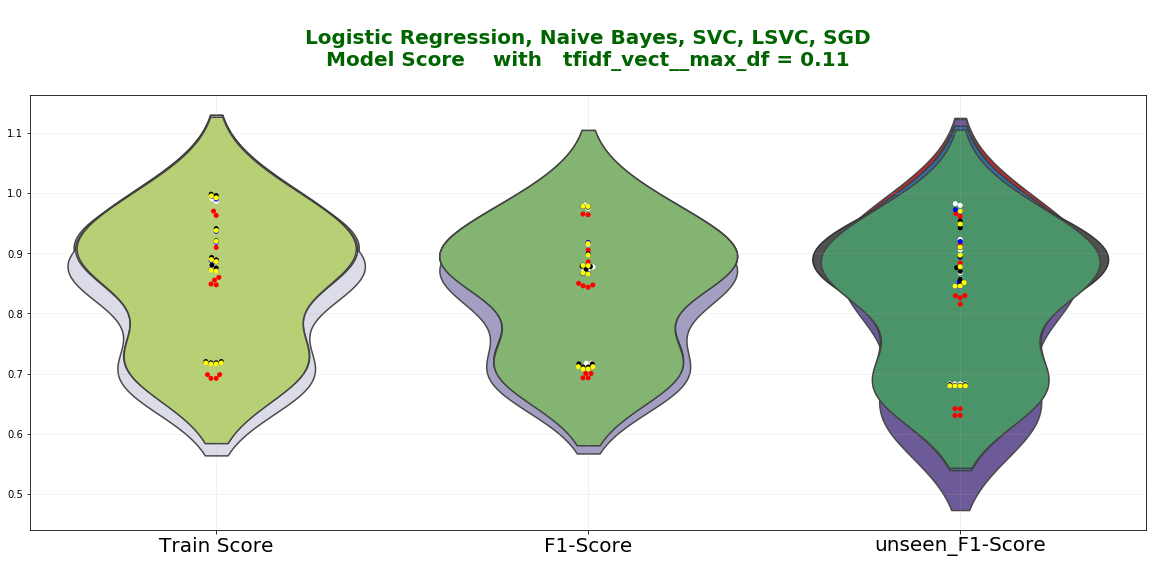

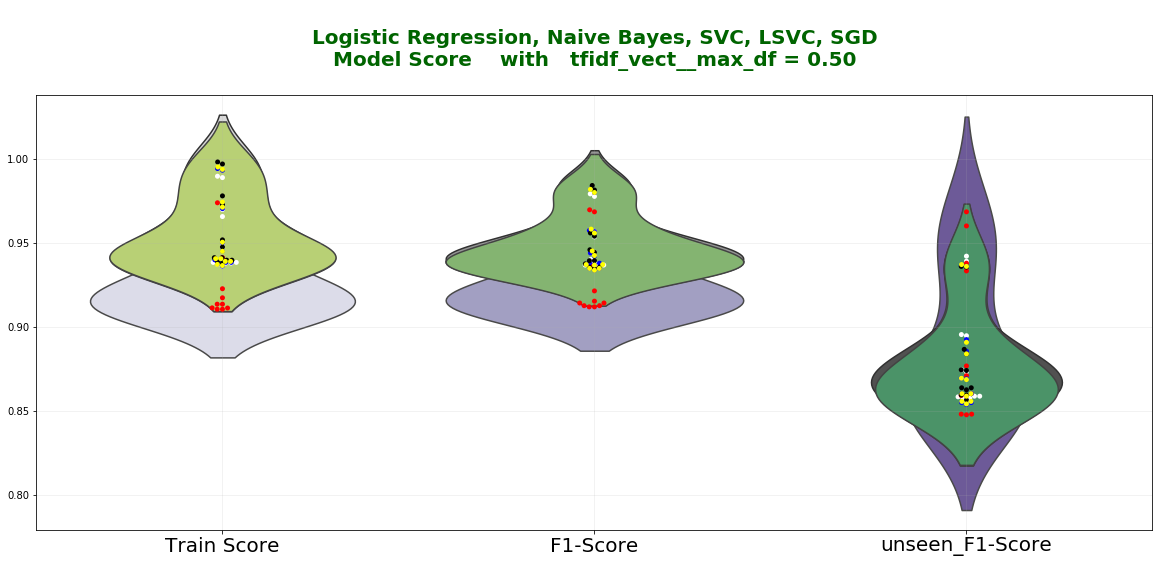

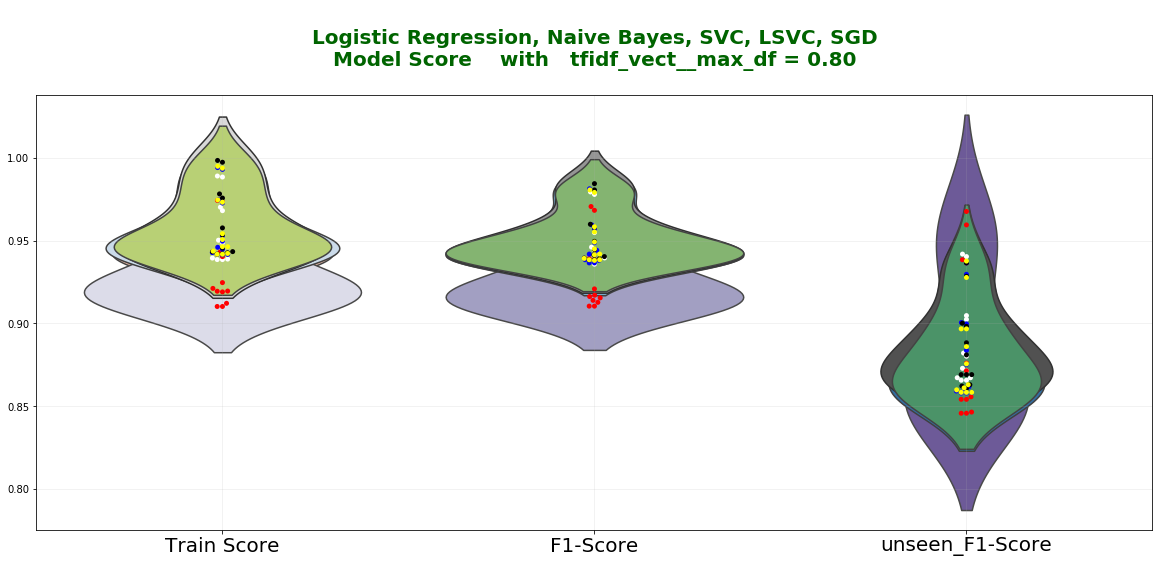

In [32]:
display(modelColorCodeTable)
for i in list(range(3)):
    # Filter Logistic Regression data by max_df sort by scores
    LRscores_max_df = \
    LRdata_df[LRdata_df.loc[:,'tfidf_vect__max_df'] == TFIDF_max[i]].sort_values(by = ['Train Score', \
                                                                                       'F1-Score', \
                                                                                       'unseen_F1-Score'], \
                                                                                 ascending = False)
    # Filter Naive Bayes data by max_df sort by scores
    NBscores_max_df = \
    NBdata_df[NBdata_df.loc[:,'tfidf_vect__max_df'] == TFIDF_max[i]].sort_values(by = ['Train Score', \
                                                                                       'F1-Score', \
                                                                                       'unseen_F1-Score'], \
                                                                                 ascending = False)
    # Filter data by max_df sort by scores
    SVCscores_max_df = \
    SVCdata_df[SVCdata_df.loc[:,'tfidf_vect__max_df'] == TFIDF_max[i]].sort_values(by = ['Train Score', \
                                                                                         'F1-Score', \
                                                                                         'unseen_F1-Score'], \
                                                                                   ascending = False)
    # Filter data by max_df sort by scores
    LSVCscores_max_df = \
    LSVCdata_df[LSVCdata_df.loc[:,'tfidf_vect__max_df'] == TFIDF_max[i]].sort_values(by = ['Train Score', \
                                                                                           'F1-Score', \
                                                                                           'unseen_F1-Score'], \
                                                                                     ascending = False)
        # Filter Naive Bayes data by max_df sort by scores
    SGDscores_max_df = \
    SGDdata_df[SGDdata_df.loc[:,'tfidf_vect__max_df'] == TFIDF_max[i]].sort_values(by = ['Train Score', \
                                                                                         'F1-Score', \
                                                                                         'unseen_F1-Score'], \
                                                                                   ascending = False)
    if i == 0:
        #display(LRscores_max_df.T.iloc[0:5].T.join())
        print('\n')
    _ = plt.figure(figsize = (20,8))
    _ = plt.title('\nLogistic Regression, Naive Bayes, SVC, LSVC, SGD\nModel Score    with   tfidf_vect__max_df = %0.2f\n' %TFIDF_max[i], \
                  size = 20, color = 'darkgreen', fontweight = 'bold')
    # Logistic Regression
    _ = sns.violinplot(data = (LRscores_max_df['Train Score'], \
                               LRscores_max_df['F1-Score'], \
                               LRscores_max_df['unseen_F1-Score']), \
                       palette= 'Reds', inner = None)
    _ = sns.swarmplot(data = (LRscores_max_df['Train Score'], \
                              LRscores_max_df['F1-Score'], \
                              LRscores_max_df['unseen_F1-Score']), \
                      color='white', edgecolor='gray')
    # Naive Bayes
    _ = sns.violinplot(data = (NBscores_max_df['Train Score'], \
                               NBscores_max_df['F1-Score'], \
                               NBscores_max_df['unseen_F1-Score']), \
                       palette= 'Purples', inner = None)
    _ = sns.swarmplot(data = (NBscores_max_df['Train Score'], \
                              NBscores_max_df['F1-Score'], \
                              NBscores_max_df['unseen_F1-Score']), \
                      color='r', edgecolor='gray')
    # SVC
    _ = sns.violinplot(data = (SVCscores_max_df['Train Score'], \
                               SVCscores_max_df['F1-Score'], \
                               SVCscores_max_df['unseen_F1-Score']), \
                       palette= 'Blues', inner = None)
    _ = sns.swarmplot(data = (SVCscores_max_df['Train Score'], \
                              SVCscores_max_df['F1-Score'], \
                              SVCscores_max_df['unseen_F1-Score']), \
                      color='b', edgecolor='gray')
    # LSVC
    _ = sns.violinplot(data = (LSVCscores_max_df['Train Score'], \
                               LSVCscores_max_df['F1-Score'], \
                               LSVCscores_max_df['unseen_F1-Score']), \
                       palette= 'Greys', inner = None)
    _ = sns.swarmplot(data = (LSVCscores_max_df['Train Score'], \
                              LSVCscores_max_df['F1-Score'], \
                              LSVCscores_max_df['unseen_F1-Score']), \
                      color='black', edgecolor='gray')
    # SGD
    _ = sns.violinplot(data = (SGDscores_max_df['Train Score'], \
                               SGDscores_max_df['F1-Score'], \
                               SGDscores_max_df['unseen_F1-Score']), \
                       palette= 'summer_r', inner = None)
    _ = sns.swarmplot(data = (SGDscores_max_df['Train Score'], \
                              SGDscores_max_df['F1-Score'], \
                              SGDscores_max_df['unseen_F1-Score']), \
                      color='yellow', edgecolor='gray')
    
    _ = plt.xticks(range(3), \
                   ['Train Score', 'F1-Score', 'unseen_F1-Score'], fontsize = 20)
    _ = plt.grid(alpha = 0.2)

    #add text to plot
#    _ = plt.text(0.1,1.1,'tfidf_vect__max_df = %0.2f' %TFIDF_max[0], fontsize = 15, color = 'b', fontweight = 'bold')

,Violine Plot Palette,Swarmplot color
Logistic Regression,Reds,White
Naive Bayes,Purples,Red
SVC (Support Vector Classifier),Blues,Black
Linear SVC,Grays,Blue
SGD,Greens,Yellow


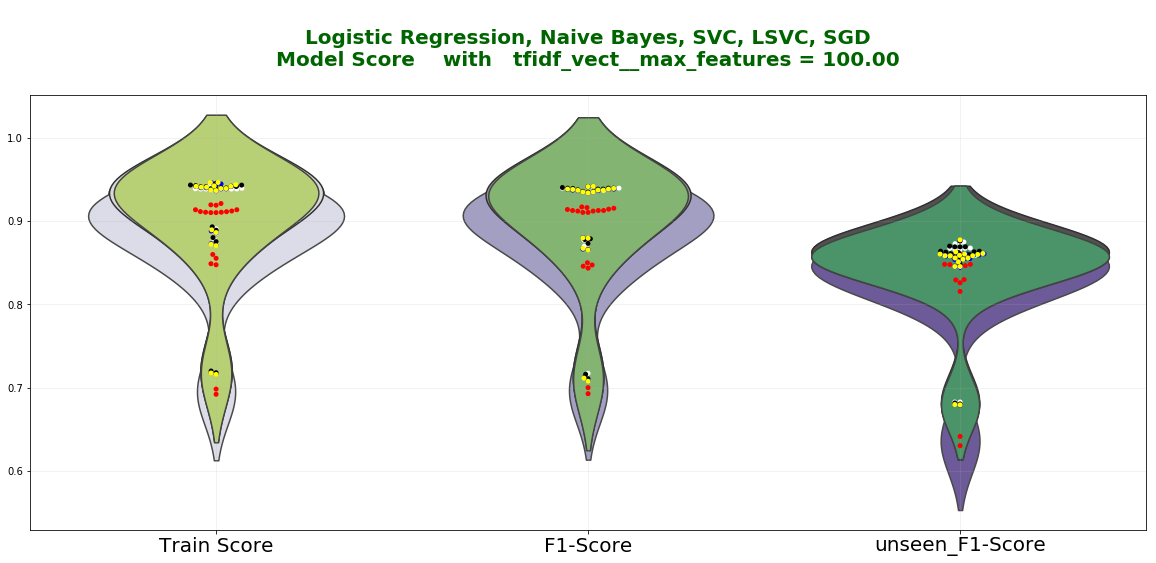

In [33]:
display(modelColorCodeTable)
for i in list(range(1)):
    # Filter Logistic Regression data by max_df sort by scores
    LRscores_max_features_df = \
    LRdata_df[LRdata_df.loc[:,'tfidf_vect__max_features'] == TFIDF_max_feat[i]].sort_values(by = 'unseen_F1-Score', \
                                                                                            ascending = False)
    # Filter Naive Bayes data by max_df sort by unseen F1 scores
    NBscores_max_features_df = \
    NBdata_df[NBdata_df.loc[:,'tfidf_vect__max_features'] == TFIDF_max_feat[i]].sort_values(by = 'unseen_F1-Score', \
                                                                                            ascending = False)
    # Filter SVC data by max_df sort by unseen F1 scores
    SVCscores_max_features_df = \
    SVCdata_df[SVCdata_df.loc[:,'tfidf_vect__max_features'] == TFIDF_max_feat[i]].sort_values(by = 'unseen_F1-Score', \
                                                                                              ascending = False)
    # Filter LSVC data by max_df sort by unseen F1 scores
    LSVCscores_max_features_df = \
    LSVCdata_df[LSVCdata_df.loc[:,'tfidf_vect__max_features'] == TFIDF_max_feat[i]].sort_values(by = 'unseen_F1-Score', \
                                                                                                ascending = False)
    # Filter SGD data by max_df sort by unseen F1 scores
    SGDscores_max_features_df = \
    SGDdata_df[SGDdata_df.loc[:,'tfidf_vect__max_features'] == TFIDF_max_feat[i]].sort_values(by = 'unseen_F1-Score', \
                                                                                              ascending = False)
    if i == 0:
        #display(LRscores_max_features_df.T.iloc[0:5].T.join())
        print('\n')
    _ = plt.figure(figsize = (20,8))
    _ = plt.title('\nLogistic Regression, Naive Bayes, SVC, LSVC, SGD\nModel Score    with   tfidf_vect__max_features = %0.2f\n' %TFIDF_max_feat[i], \
                  size = 20, color = 'darkgreen', fontweight = 'bold')
    # Logistic Regression
    _ = sns.violinplot(data = (LRscores_max_features_df['Train Score'], \
                               LRscores_max_features_df['F1-Score'], \
                               LRscores_max_features_df['unseen_F1-Score']), \
                       palette= 'Reds', inner = None)
    _ = sns.swarmplot(data = (LRscores_max_features_df['Train Score'], \
                              LRscores_max_features_df['F1-Score'], \
                              LRscores_max_features_df['unseen_F1-Score']), \
                      color='white', edgecolor='gray')
    # Naive Bayes
    _ = sns.violinplot(data = (NBscores_max_features_df['Train Score'], \
                               NBscores_max_features_df['F1-Score'], \
                               NBscores_max_features_df['unseen_F1-Score']), \
                       palette= 'Purples', inner = None)
    _ = sns.swarmplot(data = (NBscores_max_features_df['Train Score'], \
                              NBscores_max_features_df['F1-Score'], \
                              NBscores_max_features_df['unseen_F1-Score']), \
                      color='r', edgecolor='gray')
    # SVC
    _ = sns.violinplot(data = (SVCscores_max_features_df['Train Score'], \
                               SVCscores_max_features_df['F1-Score'], \
                               SVCscores_max_features_df['unseen_F1-Score']), \
                       palette= 'Blues', inner = None)
    _ = sns.swarmplot(data = (SVCscores_max_features_df['Train Score'], \
                              SVCscores_max_features_df['F1-Score'], \
                              SVCscores_max_features_df['unseen_F1-Score']), \
                      color='b', edgecolor='gray')
    # LSVC
    _ = sns.violinplot(data = (LSVCscores_max_features_df['Train Score'], \
                               LSVCscores_max_features_df['F1-Score'], \
                               LSVCscores_max_features_df['unseen_F1-Score']), \
                       palette= 'Greys', inner = None)
    _ = sns.swarmplot(data = (LSVCscores_max_features_df['Train Score'], \
                              LSVCscores_max_features_df['F1-Score'], \
                              LSVCscores_max_features_df['unseen_F1-Score']), \
                      color='black', edgecolor='gray')
    # SGD
    _ = sns.violinplot(data = (SGDscores_max_features_df['Train Score'], \
                               SGDscores_max_features_df['F1-Score'], \
                               SGDscores_max_features_df['unseen_F1-Score']), \
                       palette= 'summer_r', inner = None)
    _ = sns.swarmplot(data = (SGDscores_max_features_df['Train Score'], \
                              SGDscores_max_features_df['F1-Score'], \
                              SGDscores_max_features_df['unseen_F1-Score']), \
                      color='yellow', edgecolor='gray')
    
    _ = plt.xticks(range(3), \
                   ['Train Score', 'F1-Score', 'unseen_F1-Score'], fontsize = 20)
    _ = plt.grid(alpha = 0.2)

    #add text to plot
#    _ = plt.text(0.1,1.1,'tfidf_vect__max_features_df = %0.2f' %TFIDF_max_feat[0], fontsize = 15, color = 'b', fontweight = 'bold')

,Violine Plot Palette,Swarmplot color
Logistic Regression,Reds,White
Naive Bayes,Purples,Red
SVC (Support Vector Classifier),Blues,Black
Linear SVC,Grays,Blue
SGD,Greens,Yellow


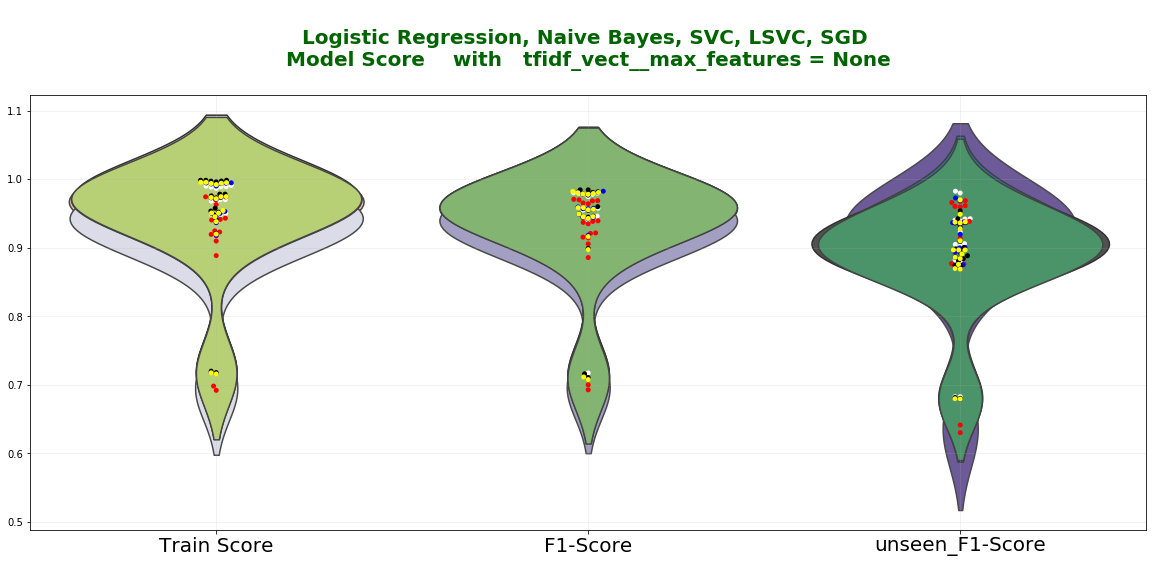

In [34]:
display(modelColorCodeTable)
for i in list(range(1)):
    # Filter Logistic Regression data by max_df sort by scores
    LRscores_max_features_df = \
    LRdata_df[LRdata_df.loc[:,'tfidf_vect__max_features'] != TFIDF_max_feat[i]].sort_values(by = ['Train Score', \
                                                                                                  'F1-Score', \
                                                                                                  'unseen_F1-Score'], \
                                                                                            ascending = False)
    # Filter Naive Bayes data by max_df sort by scores
    NBscores_max_features_df = \
    NBdata_df[NBdata_df.loc[:,'tfidf_vect__max_features'] != TFIDF_max_feat[i]].sort_values(by = ['Train Score', \
                                                                                                  'F1-Score', \
                                                                                                  'unseen_F1-Score'], \
                                                                                            ascending = False)
    # Filter data by max_df sort by scores
    SVCscores_max_features_df = \
    SVCdata_df[SVCdata_df.loc[:,'tfidf_vect__max_features'] != TFIDF_max_feat[i]].sort_values(by = ['Train Score', \
                                                                                                    'F1-Score', \
                                                                                                    'unseen_F1-Score'], \
                                                                                              ascending = False)
    # Filter data by max_df sort by scores
    LSVCscores_max_features_df = \
    LSVCdata_df[LSVCdata_df.loc[:,'tfidf_vect__max_features'] != TFIDF_max_feat[i]].sort_values(by = ['Train Score', \
                                                                                                      'F1-Score', \
                                                                                                      'unseen_F1-Score'], \
                                                                                                ascending = False)
        # Filter Naive Bayes data by max_df sort by scores
    SGDscores_max_features_df = \
    SGDdata_df[SGDdata_df.loc[:,'tfidf_vect__max_features'] != TFIDF_max_feat[i]].sort_values(by = ['Train Score', \
                                                                                                    'F1-Score', \
                                                                                                    'unseen_F1-Score'], \
                                                                                              ascending = False)
    if i == 0:
        #display(LRscores_max_features_df.T.iloc[0:5].T.join())
        print('\n')
    _ = plt.figure(figsize = (20,8))
    _ = plt.title('\nLogistic Regression, Naive Bayes, SVC, LSVC, SGD \nModel Score    with   tfidf_vect__max_features = None\n', \
                  size = 20, color = 'darkgreen', fontweight = 'bold')
    # Logistic Regression
    _ = sns.violinplot(data = (LRscores_max_features_df['Train Score'], \
                               LRscores_max_features_df['F1-Score'], \
                               LRscores_max_features_df['unseen_F1-Score']), \
                       palette= 'Reds', inner = None)
    _ = sns.swarmplot(data = (LRscores_max_features_df['Train Score'], \
                              LRscores_max_features_df['F1-Score'], \
                              LRscores_max_features_df['unseen_F1-Score']), \
                      color='white', edgecolor='gray')
    # Naive Bayes
    _ = sns.violinplot(data = (NBscores_max_features_df['Train Score'], \
                               NBscores_max_features_df['F1-Score'], \
                               NBscores_max_features_df['unseen_F1-Score']), \
                       palette= 'Purples', inner = None)
    _ = sns.swarmplot(data = (NBscores_max_features_df['Train Score'], \
                              NBscores_max_features_df['F1-Score'], \
                              NBscores_max_features_df['unseen_F1-Score']), \
                      color='r', edgecolor='gray')
    # SVC
    _ = sns.violinplot(data = (SVCscores_max_features_df['Train Score'], \
                               SVCscores_max_features_df['F1-Score'], \
                               SVCscores_max_features_df['unseen_F1-Score']), \
                       palette= 'Blues', inner = None)
    _ = sns.swarmplot(data = (SVCscores_max_features_df['Train Score'], \
                              SVCscores_max_features_df['F1-Score'], \
                              SVCscores_max_features_df['unseen_F1-Score']), \
                      color='b', edgecolor='gray')
    # LSVC
    _ = sns.violinplot(data = (LSVCscores_max_features_df['Train Score'], \
                               LSVCscores_max_features_df['F1-Score'], \
                               LSVCscores_max_features_df['unseen_F1-Score']), \
                       palette= 'Greys', inner = None)
    _ = sns.swarmplot(data = (LSVCscores_max_features_df['Train Score'], \
                              LSVCscores_max_features_df['F1-Score'], \
                              LSVCscores_max_features_df['unseen_F1-Score']), \
                      color='black', edgecolor='gray')
    # SGD
    _ = sns.violinplot(data = (SGDscores_max_features_df['Train Score'], \
                               SGDscores_max_features_df['F1-Score'], \
                               SGDscores_max_features_df['unseen_F1-Score']), \
                       palette= 'summer_r', inner = None)
    _ = sns.swarmplot(data = (SGDscores_max_features_df['Train Score'], \
                              SGDscores_max_features_df['F1-Score'], \
                              SGDscores_max_features_df['unseen_F1-Score']), \
                      color='yellow', edgecolor='gray')
    
    _ = plt.xticks(range(3), \
                   ['Train Score', 'F1-Score', 'unseen_F1-Score'], fontsize = 20)
    _ = plt.grid(alpha = 0.2)

    #add text to plot
#    _ = plt.text(0.1,1.1,'tfidf_vect__max_features_df = %0.2f' %TFIDF_max_feat[0], fontsize = 15, color = 'b', fontweight = 'bold')

,Violine Plot Palette,Swarmplot color
Logistic Regression,Reds,White
Naive Bayes,Purples,Red
SVC (Support Vector Classifier),Blues,Black
Linear SVC,Grays,Blue
SGD,Greens,Yellow


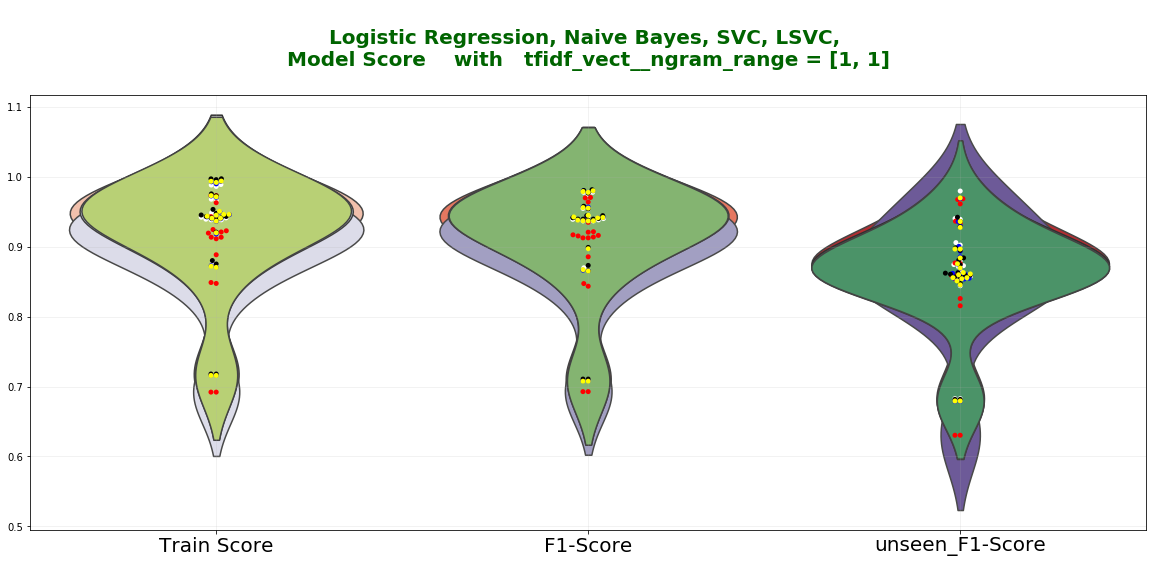

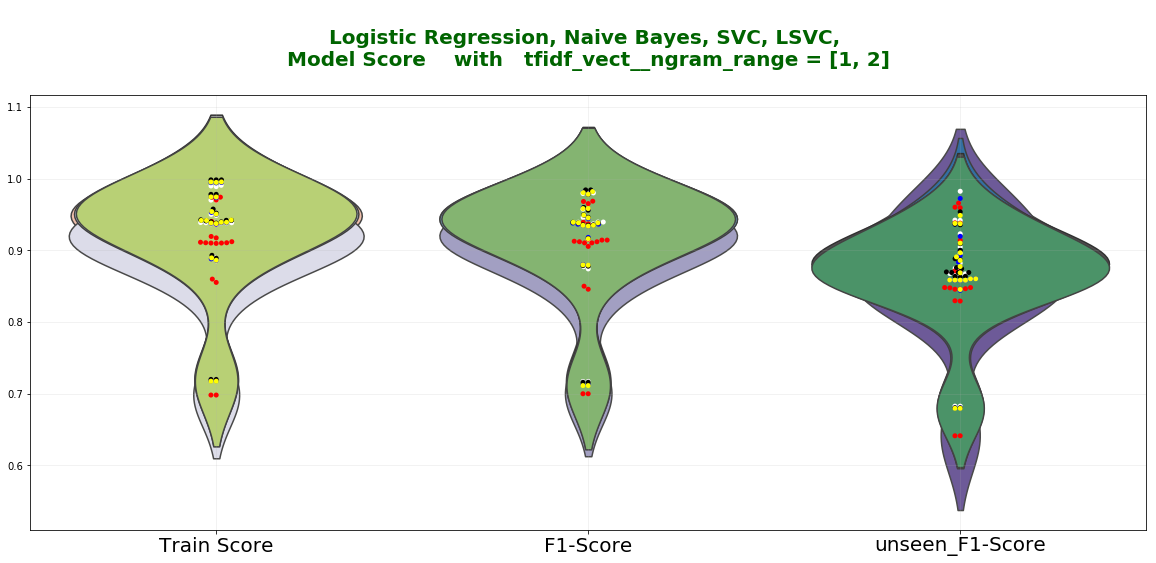

In [35]:
display(modelColorCodeTable)
for i in list(range(2)):
    LRscores_ngram_df = pd.DataFrame(columns = LRdata_df.columns)
    NBscores_ngram_df = pd.DataFrame(columns = NBdata_df.columns)
    SVCscores_ngram_df = pd.DataFrame(columns = SVCdata_df.columns)
    LSVCscores_ngram_df = pd.DataFrame(columns = LSVCdata_df.columns)
    SGDscores_ngram_df = pd.DataFrame(columns = SGDdata_df.columns)
    for j in list(range(len(LRdata_df))):
        if LRdata_df.loc[:,'tfidf_vect__ngram_range'][j]==[1, TFIDF_ngram[i]]:
            LRscores_ngram_df = LRscores_ngram_df.append(LRdata_df.iloc[j,:])
        if NBdata_df.loc[:,'tfidf_vect__ngram_range'][j]==[1, TFIDF_ngram[i]]:
            NBscores_ngram_df = NBscores_ngram_df.append(NBdata_df.iloc[j,:])
        if SVCdata_df.loc[:,'tfidf_vect__ngram_range'][j]==[1, TFIDF_ngram[i]]:
            SVCscores_ngram_df = SVCscores_ngram_df.append(SVCdata_df.iloc[j,:])
        if LSVCdata_df.loc[:,'tfidf_vect__ngram_range'][j]==[1, TFIDF_ngram[i]]:
            LSVCscores_ngram_df = LSVCscores_ngram_df.append(LSVCdata_df.iloc[j,:])
        if SGDdata_df.loc[:,'tfidf_vect__ngram_range'][j]==[1, TFIDF_ngram[i]]:
            SGDscores_ngram_df = SGDscores_ngram_df.append(SGDdata_df.iloc[j,:])
    # Filter Logistic Regression sort scores by ngram
    LRscores_ngram_df = LRscores_ngram_df.sort_values(by = 'unseen_F1-Score', ascending = False)
    # Filter Logistic Regression sort scores by ngram
    NBscores_ngram_df = NBscores_ngram_df.sort_values(by = 'unseen_F1-Score', ascending = False)
    # Filter Logistic Regression sort scores by ngram
    SVCscores_ngram_df = SVCscores_ngram_df.sort_values(by = 'unseen_F1-Score', ascending = False)
    # Filter Logistic Regression sort scores by ngram
    LSVCscores_ngram_df = LSVCscores_ngram_df.sort_values(by = 'unseen_F1-Score', ascending = False)
    # Filter Logistic Regression sort scores by ngram
    SGDscores_ngram_df = SGDscores_ngram_df.sort_values(by = 'unseen_F1-Score', ascending = False)

    if i == 0:
        print('\n')
    _ = plt.figure(figsize = (20,8))
    _ = plt.title('\nLogistic Regression, Naive Bayes, SVC, LSVC, \nModel Score    with   tfidf_vect__ngram_range = [1, %d]\n' %TFIDF_ngram[i], \
                  size = 20, color = 'darkgreen', fontweight = 'bold')
    # Logistic Regression
    _ = sns.violinplot(data = (LRscores_ngram_df['Train Score'], \
                               LRscores_ngram_df['F1-Score'], \
                               LRscores_ngram_df['unseen_F1-Score']), \
                       palette= 'Reds', inner = None)
    _ = sns.swarmplot(data = (LRscores_ngram_df['Train Score'], \
                              LRscores_ngram_df['F1-Score'], \
                              LRscores_ngram_df['unseen_F1-Score']), \
                      color='white', edgecolor='gray')
    # Naive Bayes
    _ = sns.violinplot(data = (NBscores_ngram_df['Train Score'], \
                               NBscores_ngram_df['F1-Score'], \
                               NBscores_ngram_df['unseen_F1-Score']), \
                       palette= 'Purples', inner = None)
    _ = sns.swarmplot(data = (NBscores_ngram_df['Train Score'], \
                              NBscores_ngram_df['F1-Score'], \
                              NBscores_ngram_df['unseen_F1-Score']), \
                      color='r', edgecolor='gray')
    # SVC
    _ = sns.violinplot(data = (SVCscores_ngram_df['Train Score'], \
                               SVCscores_ngram_df['F1-Score'], \
                               SVCscores_ngram_df['unseen_F1-Score']), \
                       palette= 'Blues', inner = None)
    _ = sns.swarmplot(data = (SVCscores_ngram_df['Train Score'], \
                              SVCscores_ngram_df['F1-Score'], \
                              SVCscores_ngram_df['unseen_F1-Score']), \
                      color='b', edgecolor='gray')
    # LSVC
    _ = sns.violinplot(data = (LSVCscores_ngram_df['Train Score'], \
                               LSVCscores_ngram_df['F1-Score'], \
                               LSVCscores_ngram_df['unseen_F1-Score']), \
                       palette= 'Greys', inner = None)
    _ = sns.swarmplot(data = (LSVCscores_ngram_df['Train Score'], \
                              LSVCscores_ngram_df['F1-Score'], \
                              LSVCscores_ngram_df['unseen_F1-Score']), \
                      color='black', edgecolor='gray')
    # SGD
    _ = sns.violinplot(data = (SGDscores_ngram_df['Train Score'], \
                               SGDscores_ngram_df['F1-Score'], \
                               SGDscores_ngram_df['unseen_F1-Score']), \
                       palette= 'summer_r', inner = None)
    _ = sns.swarmplot(data = (SGDscores_ngram_df['Train Score'], \
                              SGDscores_ngram_df['F1-Score'], \
                              SGDscores_ngram_df['unseen_F1-Score']), \
                      color='yellow', edgecolor='gray')
    
    _ = plt.xticks(range(3), \
                   ['Train Score', 'F1-Score', 'unseen_F1-Score'], fontsize = 20)
    _ = plt.grid(alpha = 0.2)

    #add text to plot
#    _ = plt.text(0.1,1.1,'tfidf_vect__max_df = %0.2f' %TFIDF_max[0], fontsize = 15, color = 'b', fontweight = 'bold')

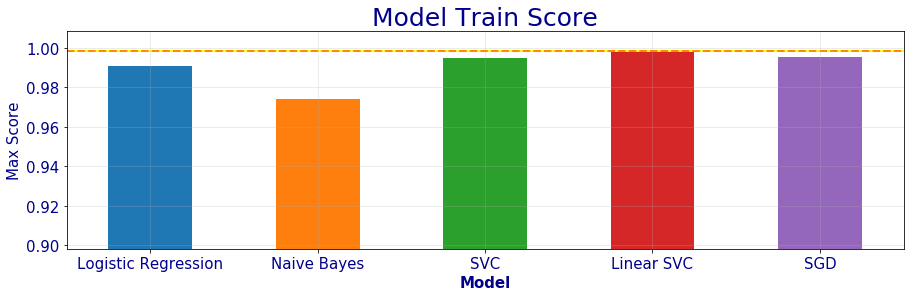

In [36]:
train_comp = pd.DataFrame([LR_performance.T.iloc[1], \
                           NB_performance.T.iloc[1], \
                           SVC_performance.T.iloc[1], \
                           LSVC_performance.T.iloc[1], \
                           SGD_performance.T.iloc[1]], \
                          index = ['Logistic Regression','Naive Bayes', 'SVC', 'Linear SVC', 'SGD'], \
                          columns = None).T
train_comp

p = train_comp.max().plot.bar(figsize = (15,4))
mx = np.max(train_comp.max())
_ = plt.title('Model Train Score', fontsize = 25, color = 'darkblue')
_ = p.set_ylim(mx-0.1,mx+0.01)
_ = plt.axhline(y = mx, color = 'yellow', lw = 2, linestyle = '-')
_ = plt.axhline(y = mx, color = 'darkorange', lw = 2, linestyle = '--')
_ = plt.grid(alpha = 0.3)
_ = plt.xticks(rotation = 0, color = 'darkblue', fontsize = 15)
_ = plt.xlabel('Model', color = 'darkblue', fontsize = 15, fontweight = 'bold')
_ = plt.yticks(rotation = 0, color = 'darkblue', fontsize = 15)
_ = plt.ylabel('Max Score', fontsize = 15, color = 'darkblue')

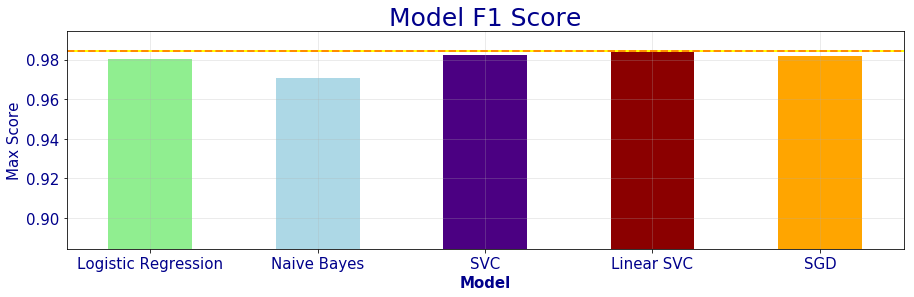

In [37]:
F1_comp = pd.DataFrame([LR_performance.T.iloc[2], \
                           NB_performance.T.iloc[2], \
                           SVC_performance.T.iloc[2], \
                           LSVC_performance.T.iloc[2], \
                           SGD_performance.T.iloc[2]], \
                          index = ['Logistic Regression','Naive Bayes', 'SVC', 'Linear SVC', 'SGD'], \
                          columns = None).T

p = F1_comp.max().plot.bar(figsize = (15,4), color = ['lightgreen', 'lightblue', 'indigo', 'darkred', 'orange'])
mx = np.max(F1_comp.max())
_ = plt.title('Model F1 Score', fontsize = 25, color = 'darkblue')
_ = p.set_ylim(mx-0.1,mx+0.01)
_ = plt.axhline(y = mx, color = 'yellow', lw = 2, linestyle = '-')
_ = plt.axhline(y = mx, color = 'darkorange', lw = 2, linestyle = '--')
_ = plt.grid(alpha = 0.3)
_ = plt.xticks(rotation = 0, color = 'darkblue', fontsize = 15)
_ = plt.xlabel('Model', color = 'darkblue', fontsize = 15, fontweight = 'bold')
_ = plt.yticks(rotation = 0, color = 'darkblue', fontsize = 15)
_ = plt.ylabel('Max Score', fontsize = 15, color = 'darkblue')

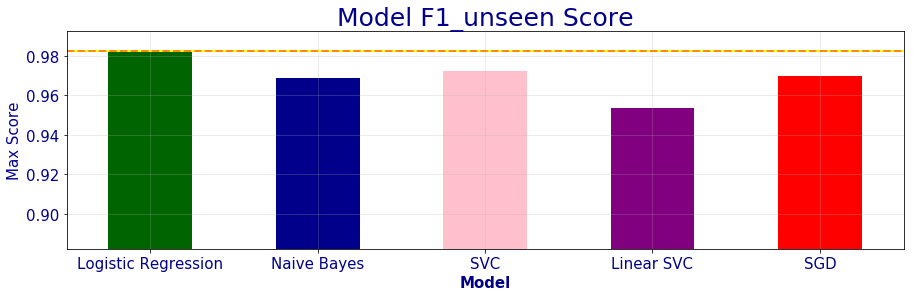

In [38]:
F1_unseen_comp = pd.DataFrame([LR_performance.T.iloc[3], \
                           NB_performance.T.iloc[3], \
                           SVC_performance.T.iloc[3], \
                           LSVC_performance.T.iloc[3], \
                           SGD_performance.T.iloc[3]], \
                          index = ['Logistic Regression','Naive Bayes', 'SVC', 'Linear SVC', 'SGD'], \
                          columns = None).T

p = F1_unseen_comp.max().plot.bar(figsize = (15,4), color = ['darkgreen', 'darkblue', 'pink', 'purple', 'red'])
mx = np.max(F1_unseen_comp.max())
_ = plt.title('Model F1_unseen Score', fontsize = 25, color = 'darkblue')
_ = p.set_ylim(mx-0.1,mx+0.01)
_ = plt.axhline(y = mx, color = 'yellow', lw = 2, linestyle = '-')
_ = plt.axhline(y = mx, color = 'darkorange', lw = 2, linestyle = '--')
_ = plt.grid(alpha = 0.3)
_ = plt.xticks(rotation = 0, color = 'darkblue', fontsize = 15)
_ = plt.xlabel('Model', color = 'darkblue', fontsize = 15, fontweight = 'bold')
_ = plt.yticks(rotation = 0, color = 'darkblue', fontsize = 15)
_ = plt.ylabel('Max Score', fontsize = 15, color = 'darkblue')

***
***
# <span style = 'color:darkblue'> <center> $ \textrm {CONCLUSION} $

***
***
</span>

#### The performance results for all five models show a good score in correctly classifying the spam emails. The initial train and test set show a superior performance for Linear SVC model. Although Linear SVC outperforms the other models, when applying the trained model on unseen test set, the Logistic regression steals the show with the highest F1 score of 0.9824 with max_df = 0.11, min_df = 0.01, max_features = None, and ngram = [1,2]. Leading to the conclusion that based on the training set, Logistic Regression model performs the best and can be used as the first choice in classifying the emails as spam.
#### Since the model training is independent of the unseen test set, all the observations are based on the model scores achieved when applied to the unseen test set.

#### The swarm plot distribution of scores for unseen test set is spread out for varying min_df parameter. As the min_df increases in value, the combined scores suffer as the lowest score reaches 65% range. The max_df variation causes the overall score distribution to drop to 85% range. Similar to min_df as max_features are set to 100 total words of vocabulary, although some of the scores fall in 65% range, a strong distribution close to 90% is present. As the max features changes to include all words, the score performance is mostly distributed in the upper 90% range showing a better performance.
#### Finally, for n-gram variation the scores are distributed between 65% and upper 90%. Although there are slight distinguishing differences in model scores, both n_gram = [1,1] and  [1,2] lead to similar performance.

#### Notable observasion here is that generalized models, such as the Logistic Regression, perform better when including all features and/or extending n-grams to include 2 or 3 tocken words. Models that are not generalized, such as Naive Bayes, tend to overfit the training set and usually do not perform as optimized.
***
***
#### Following TFIDF hyperparameter variation were used to examine how they affect model score performance: 
##### minimum document frequency (min_df = [0.01, 0.05, 0.1] ) )
##### maximum document frequency (max_df = [0.1, 0.5, 0.8] ),
##### maximum features (max_features = [ 100, NAN] )
##### n_gram range set to ([1,1], [1,2])
